In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset, random_split

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# RFLAF model

In [21]:
# Functions
class Mysin(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        indicator = torch.where((-1 <= input) & (input <= 1), torch.tensor(1.0), torch.tensor(0.0))
        result = torch.sin(input*torch.tensor(torch.pi)) * indicator
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # 这里要加逗号把tuple消掉
        indicator = torch.where((-1 <= input) & (input <= 1), torch.tensor(1.0), torch.tensor(0.0))
        grad_input = grad_output * torch.cos(input*torch.tensor(torch.pi)) * torch.tensor(torch.pi) * indicator
        return grad_input

class Myfunc2(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        indicator = torch.where((0 <= input) & (input <= 1), torch.tensor(1.0), torch.tensor(0.0))
        result = torch.sin(input*torch.tensor(torch.pi)) * indicator
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # 这里要加逗号把tuple消掉
        indicator = torch.where((0 <= input) & (input <= 1), torch.tensor(1.0), torch.tensor(0.0))
        grad_input = grad_output * torch.cos(input*torch.tensor(torch.pi)) * torch.tensor(torch.pi) * indicator
        return grad_input
    
class Myfunc3(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        indicator0 = torch.where((-1.5 <= input) & (input <= -0.5), torch.tensor(1.0), torch.tensor(0.0))
        indicator1 = torch.where((0.5 <= input) & (input <= 1.5), torch.tensor(1.0), torch.tensor(0.0))
        f0 = torch.tensor(-1.0) * torch.sin((input+torch.tensor(0.5))*torch.tensor(torch.pi))
        f1 = torch.tensor(1.0) * torch.sin((input-torch.tensor(0.5))*torch.tensor(torch.pi))
        result = f0 * indicator0 + f1 * indicator1
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        indicator0 = torch.where((-1.5 <= input) & (input <= -0.5), torch.tensor(1.0), torch.tensor(0.0))
        indicator1 = torch.where((0.5 <= input) & (input <= 1.5), torch.tensor(1.0), torch.tensor(0.0))
        f0 = torch.tensor(-torch.pi) * torch.cos((input+torch.tensor(0.5))*torch.tensor(torch.pi))
        f1 = torch.tensor(torch.pi) * torch.cos((input-torch.tensor(0.5))*torch.tensor(torch.pi))
        result = f0 * indicator0 + f1 * indicator1
        grad_input = grad_output * result
        return grad_input

class Cos(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.cos(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output * (-torch.sin(input))

class RBFLayer(nn.Module):
    def __init__(self, center, gamma):
        super(RBFLayer, self).__init__()
        self.c = center
        self.h = gamma

    def forward(self, input):
        result = -(input-self.c)**2/(2*self.h**2)
        return torch.exp(result)

In [22]:
# Models
class RFLAF(nn.Module):
    def __init__(self, N, M, input_dim, paralist):
        super(RFLAF, self).__init__()
        self.M = torch.sqrt(torch.tensor(M*N*paralist[0][1]*1.0))
        self.W = nn.Parameter(torch.randn(input_dim, M)) 
        self.W.requires_grad = False 
        self.v = nn.Parameter(torch.randn(M)/torch.sqrt(torch.tensor(M*1.0)))  
        self.a = nn.Parameter(torch.randn(N)/torch.sqrt(torch.tensor(N*1.0)))
        self.rbfs = nn.ModuleList([RBFLayer(torch.tensor(center), torch.tensor(gamma)) for center, gamma in paralist])

    def forward(self, x):
        # x: [batch_size, input_dim]
        xW = torch.matmul(x, self.W)  # [batch_size, M]
        A = torch.stack([rbf(xW) for rbf in self.rbfs], dim=2) # [batch_size, M, N]
        Aa = torch.matmul(A, self.a) # [batch_size, M]
        vAa = torch.matmul(Aa, self.v) # [batch_size]
        return vAa

class target_func(nn.Module):
    def __init__(self, M, input_dim, actfunc):
        super(target_func, self).__init__()
        self.M = torch.tensor(M*1.0)
        self.W = nn.Parameter(torch.randn(input_dim, M)) # [input_dim, M]
        self.W.requires_grad = False 

        self.b1 = torch.randn(input_dim)
        self.b2 = torch.randn(input_dim)
        
        if actfunc=='sin':
            self.func = Mysin.apply
            amplitude = torch.tensor(20.0)
        elif actfunc=='tru':
            self.func = Myfunc2.apply
            amplitude = torch.tensor(16.0)
        elif actfunc=='zoi':
            self.func = Myfunc3.apply
            amplitude = torch.tensor(5.0)

        self.v = nn.Parameter(torch.randn(M))
        self.v.requires_grad = False
        self.v.data = torch.max(torch.matmul(self.b1, self.W),torch.matmul(self.b2, self.W))*amplitude

    def forward(self, x):
        # x: [batch_size, input_dim]
        xW = torch.matmul(x, self.W)  # [batch_size, M]
        act_outputs = torch.matmul(self.func(xW),self.v)
        result = torch.div(act_outputs, self.M)
        return result

In [23]:
# Regularizer
class CustomRegularizer(nn.Module):
    def __init__(self, lambda1, lambda2, N, M):
        super(CustomRegularizer, self).__init__()
        self.lambda1 = torch.tensor(lambda1)
        self.lambda2 = torch.tensor(lambda2)
        self.N = torch.tensor(N*1.0)
        self.M = torch.tensor(M*1.0)

    def forward(self, a, v):
        L1_term = self.lambda2 * torch.div(torch.abs(a).sum(), self.N)
        reg_term = L1_term + self.lambda1 * (torch.div(torch.sum(a**2),torch.sqrt(self.N)) - torch.div(torch.sum(v**2),torch.sqrt(self.M)))**2
        return reg_term

In [24]:
# # Create datasets
# torch.manual_seed(125)

# task_name = 'zoi' # 'sin' 'tru'

# M = 100000
# input_dim = 2
# sample_size = 15000

# X = torch.randn(sample_size, input_dim) 
# groundtruth = target_func(M, input_dim, task_name)

# bs = 200
# nmbs = sample_size//bs
# ylist=[]

# for i in range(nmbs):
#     xbch = X[i*bs:(i+1)*bs]
#     ybch = groundtruth(xbch)
#     ylist.append(ybch)

# y = torch.cat(ylist, dim=0)

# np.save(f'./data/X_{task_name}.npy', X.numpy())
# np.save(f'./data/y_{task_name}.npy', y.detach().numpy())

In [25]:
# Setting parameters
h = 0.02
N = 401
hlist=h * np.ones(N)
clist=np.linspace(-2,2,N)
paralist = list(zip(clist, hlist))
print(N)

401


In [26]:
# Setting RFLAF model
M = 1000  
input_dim = 2
actfunc = 'LAF'
model = RFLAF(len(paralist), M, input_dim, paralist)
lambda1 = 1
lambda2 = 0.01
regularizer = CustomRegularizer(lambda1, lambda2, len(paralist), M)

In [27]:
run_epoch = 0
train_loss_values = []
test_loss_values = []

$\sigma_1$,$\sigma_2$,$\sigma_3$ corresponds to task_name='sin','tru','zoi'.

In [28]:
# Load data
task_name = 'zoi'
X = np.load(f'./data/X_{task_name}.npy')[:15000]
y = np.load(f'./data/y_{task_name}.npy')[:15000]
X = torch.tensor(X)
y = torch.tensor(y)

dataset = TensorDataset(X, y)

test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Train
num_epochs = 15
warmup_iter = 8
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_iter)

for epoch in range(1+run_epoch,num_epochs+run_epoch+1):
    iter=0
    train_loss = 0.0
    model.train()
    for X_batch, y_batch in train_loader:
        iter+=1
        
        outputs = model(X_batch)
        
        reg_value = regularizer(model.a,model.v)
        loss = criterion(outputs, y_batch) + reg_value

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if iter <= warmup_iter:
            warmup_scheduler.step()
        else:
            optimizer.step()
        train_loss += loss.item()-reg_value.item()
        
        print(f'Epoch [{epoch}/{num_epochs+run_epoch}], Iter [{iter}], Loss: {loss.item():.6f}\t={loss.item()-reg_value.item():.6f}\t+{reg_value.item():.6f}')
    
    epoch_loss = train_loss / len(train_loader)
    train_loss_values.append(epoch_loss)
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_loss_values.append(test_loss)
    print(f'Epoch {epoch}/{num_epochs+run_epoch}, Train Loss: {epoch_loss}, Test Loss: {test_loss}')
run_epoch+=num_epochs

Epoch [1/15], Iter [1], Loss: 1.718642	=1.717893	+0.000750
Epoch [1/15], Iter [2], Loss: 1.677324	=1.676575	+0.000750
Epoch [1/15], Iter [3], Loss: 1.537468	=1.536718	+0.000750
Epoch [1/15], Iter [4], Loss: 1.920336	=1.919585	+0.000750
Epoch [1/15], Iter [5], Loss: 1.697958	=1.697207	+0.000751
Epoch [1/15], Iter [6], Loss: 1.761943	=1.761191	+0.000752
Epoch [1/15], Iter [7], Loss: 1.770131	=1.769378	+0.000753
Epoch [1/15], Iter [8], Loss: 1.657215	=1.656463	+0.000753
Epoch [1/15], Iter [9], Loss: 1.399195	=1.398442	+0.000753
Epoch [1/15], Iter [10], Loss: 1.441007	=1.440256	+0.000751
Epoch [1/15], Iter [11], Loss: 0.984125	=0.983378	+0.000747
Epoch [1/15], Iter [12], Loss: 0.775145	=0.774405	+0.000740
Epoch [1/15], Iter [13], Loss: 0.540355	=0.539625	+0.000730
Epoch [1/15], Iter [14], Loss: 0.320633	=0.319914	+0.000718
Epoch [1/15], Iter [15], Loss: 0.155946	=0.155240	+0.000706
Epoch [1/15], Iter [16], Loss: 0.266502	=0.265808	+0.000694
Epoch [1/15], Iter [17], Loss: 0.383209	=0.382523

In [37]:
# Save model
torch.save(model.state_dict(), f'./models/model_{task_name}_LAF.pth')

Deviation of the predicted values:
	gt	1.80	pred	1.82
	gt	0.62	pred	0.61
	gt	1.32	pred	1.30
	gt	2.11	pred	2.14
	gt	0.34	pred	0.32
	gt	0.07	pred	0.05
	gt	0.64	pred	0.63
	gt	2.15	pred	2.16
	gt	1.09	pred	1.06
	gt	1.11	pred	1.09
Test data deviate: 0.011736	Train data deviate: 0.009839


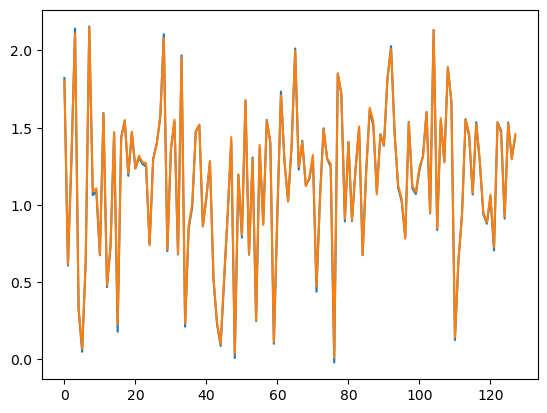

In [48]:
# Plot the prediction deviation
model.eval()
Xstr, ystr = train_loader.__iter__().__next__()
Xste, yste = test_loader.__iter__().__next__()
with torch.no_grad():
    pred_y_tr = model(Xstr)
    pred_y_te = model(Xste)
    
plt.plot(range(len(Xstr)), pred_y_te, range(len(Xste)), yste)

print('Deviation of the predicted values:')
for i in range(10):
    print("\tgt\t{:.2f}\tpred\t{:.2f}".format(yste[i],pred_y_te[i]))
residual_tr = (pred_y_tr-ystr).detach().numpy()
residual_te = (pred_y_te-yste).detach().numpy()
print(f'Test data deviate: {(np.abs(residual_te)).mean():.6f}\tTrain data deviate: {(np.abs(residual_tr)).mean():.6f}')

In [49]:
# Compute the learned activation function through the learned weights of RBFs
def testrbf(x, paralist, coef):
    paralen = len(paralist)
    result = 0
    for i in range(paralen):
        c, h = paralist[i]
        result += coef[i]*np.exp(-(x-c)**2/(2*h**2))
    return result

coef = model.a.detach().numpy()
# plt.plot(range(coef.shape[0]),coef)

x_list = np.linspace(-3,3,1001)
y_list = list()
for x_item in x_list:
    y_list.append(testrbf(x_item, paralist, coef))
y_list = np.array(y_list) # Learned curve

if task_name=='sin':
    mysinfunc = Mysin.apply
elif task_name=='tru':
    mysinfunc = Myfunc2.apply
elif task_name=='zoi':
    mysinfunc = Myfunc3.apply
y_list2 = mysinfunc(torch.tensor(x_list)).numpy() # Ground truth function

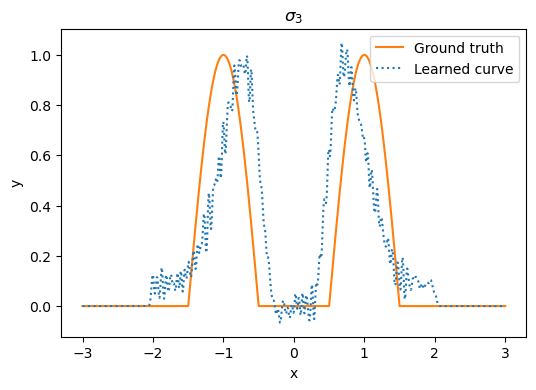

In [50]:
# Plot the learned activation function
plt.figure(figsize=(6,4))
colors = ['#ff7f0e','#1f77b4']
plt.plot(x_list, y_list2, label='Ground truth', ls='-', color=colors[0])
plt.plot(x_list, y_list*(-4.3), label='Learned curve', ls=':', color=colors[1])
plt.xlabel('x')
plt.ylabel('y')
if task_name=='sin':
    plt.title(r'$\sigma_1$')
elif task_name=='tru':
    plt.title(r'$\sigma_2$')
elif task_name=='zoi':
    plt.title(r'$\sigma_3$')
    plt.legend()
plt.savefig(f"learned_func_{task_name}.pdf", format='pdf')
plt.show()

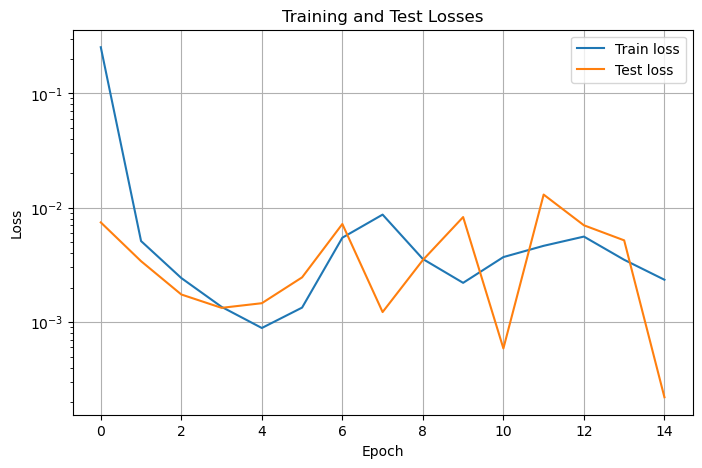

In [51]:
# Plot loss curves
task_name2 = task_name + '_' + actfunc
# Save loss
np.savetxt(f"./losses/{task_name2}_train_losses.txt", train_loss_values)
np.savetxt(f"./losses/{task_name2}_test_losses.txt", test_loss_values)

# # Load loss
# train_loss_values = np.loadtxt(f"./losses/{task_name2}_train_losses.txt")
# test_loss_values = np.loadtxt(f"./losses/{task_name2}_test_losses.txt")

# Plot loss
plt.figure(figsize=(8, 5))
# plt.plot(train_loss_values, label='Train loss')
# plt.plot(test_loss_values, label='Test loss')
plt.semilogy(train_loss_values, label='Train loss')
plt.semilogy(test_loss_values, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(True)

# Save figure
plt.savefig(f"{task_name2}_loss_curve.pdf", format='pdf')
plt.show()

# Comparison experiments

In [52]:
# Comparisons: standard random feature models
class BaseRF(nn.Module):
    def __init__(self, input_dim, hidden_dim, actfunc='relu'):
        super(BaseRF, self).__init__()
        self.M = torch.tensor(hidden_dim*1.0, requires_grad=False)
        self.weight = nn.Parameter(torch.randn(input_dim, hidden_dim), requires_grad=False)
        self.v = nn.Parameter(torch.randn(hidden_dim)/torch.sqrt(self.M))
        if actfunc=='relu':
            self.actfunc = nn.ReLU()
        elif actfunc=='tanh':
            self.actfunc = nn.Tanh()
        elif actfunc=='cos':
            self.actfunc = Cos.apply
        elif actfunc=='silu':
            self.actfunc = nn.SiLU()
        elif actfunc=='gelu':
            self.actfunc = nn.GELU()
        elif actfunc=='softplus':
            self.actfunc = nn.Softplus()
        elif actfunc=='sigmoid':
            self.actfunc = nn.Sigmoid()
        elif actfunc=='elu':
            self.actfunc = nn.ELU()
        elif actfunc=='RBF1':
            self.actfunc = RBFLayer(0.0, 0.5)
        elif actfunc=='RBF2':
            self.actfunc = RBFLayer(1.5, 0.5)

    def forward(self, x):
        x = self.actfunc(torch.matmul(x, self.weight))
        x = torch.matmul(x, self.v)
        return x

In [53]:
# Setting model
task_name = 'zoi'

actfunc_list = ['relu', 'tanh', 'cos', 'silu', 'gelu', 'softplus', 'sigmoid', 'elu', 'RBF1', 'RBF2']

# X = np.load(f'./data/X_{task_name}.npy')[:15000]
# y = np.load(f'./data/y_{task_name}.npy')[:15000]
# X = torch.tensor(X)
# y = torch.tensor(y)

# dataset = TensorDataset(X, y)

# test_size = int(0.2 * len(dataset))
# train_size = len(dataset) - test_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for actfunc in actfunc_list:
    # train model
    model = BaseRF(input_dim, M + N, actfunc) # Setting models of the same parameter number as RFLAF
    run_epoch = 0
    train_loss_values = []
    test_loss_values = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # weight_decay for BaseRF

    num_epochs = 15
    warmup_iter = 8
    warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_iter)

    for epoch in range(1+run_epoch,num_epochs+run_epoch+1):
        iter=0
        train_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            iter+=1
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iter <= warmup_iter:
                warmup_scheduler.step()
            else:
                optimizer.step()
            train_loss += loss.item()
            
            print(f'Epoch [{epoch}/{num_epochs+run_epoch}], Iter [{iter}], Loss: {loss.item():.6f}\t={loss.item():.6f}')
        
        epoch_loss = train_loss / len(train_loader)
        train_loss_values.append(epoch_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_loss_values.append(test_loss)
        
        print(f'Epoch {epoch}/{num_epochs+run_epoch}, Train Loss: {epoch_loss}, Test Loss: {test_loss}')
    run_epoch+=num_epochs
    
    # Save losses and model parameters
    task_name2 = task_name + '_' + actfunc
    torch.save(model.state_dict(), f'./models/model_{task_name2}.pth')
    np.savetxt(f"./losses/{task_name2}_train_losses.txt", train_loss_values)
    np.savetxt(f"./losses/{task_name2}_test_losses.txt", test_loss_values)

Epoch [1/15], Iter [1], Loss: 2.047134	=2.047134
Epoch [1/15], Iter [2], Loss: 1.809226	=1.809226
Epoch [1/15], Iter [3], Loss: 1.515787	=1.515787
Epoch [1/15], Iter [4], Loss: 1.164957	=1.164957
Epoch [1/15], Iter [5], Loss: 0.838370	=0.838370
Epoch [1/15], Iter [6], Loss: 0.990910	=0.990910
Epoch [1/15], Iter [7], Loss: 1.205627	=1.205627
Epoch [1/15], Iter [8], Loss: 1.045831	=1.045831
Epoch [1/15], Iter [9], Loss: 1.053982	=1.053982
Epoch [1/15], Iter [10], Loss: 1.234622	=1.234622
Epoch [1/15], Iter [11], Loss: 1.239336	=1.239336
Epoch [1/15], Iter [12], Loss: 1.422538	=1.422538
Epoch [1/15], Iter [13], Loss: 0.907151	=0.907151
Epoch [1/15], Iter [14], Loss: 0.980769	=0.980769
Epoch [1/15], Iter [15], Loss: 0.680223	=0.680223
Epoch [1/15], Iter [16], Loss: 1.331225	=1.331225
Epoch [1/15], Iter [17], Loss: 1.339844	=1.339844
Epoch [1/15], Iter [18], Loss: 1.300293	=1.300293
Epoch [1/15], Iter [19], Loss: 0.750019	=0.750019
Epoch [1/15], Iter [20], Loss: 1.047579	=1.047579
Epoch [1/

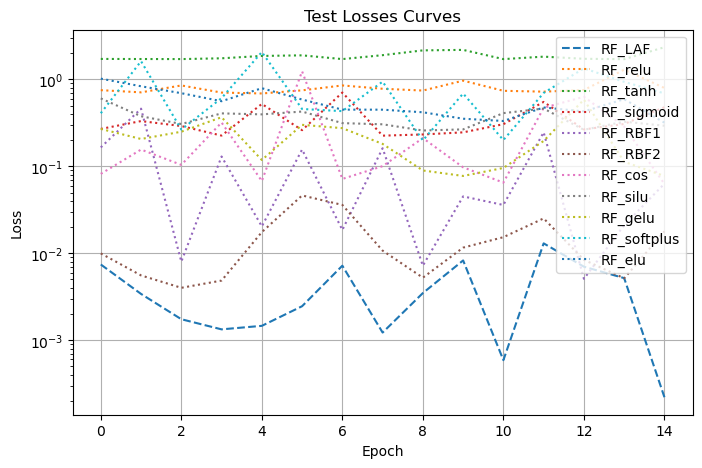

In [57]:
# Plot loss curves
# task_name = 'zoi'
losstype = 'test'

RFLAF_loss_values = np.loadtxt(f"./losses/{task_name}_LAF_{losstype}_losses.txt")
relu_loss_values = np.loadtxt(f"./losses/{task_name}_relu_{losstype}_losses.txt")
tanh_loss_values = np.loadtxt(f"./losses/{task_name}_tanh_{losstype}_losses.txt")
cos_loss_values = np.loadtxt(f"./losses/{task_name}_cos_{losstype}_losses.txt")
silu_loss_values = np.loadtxt(f"./losses/{task_name}_silu_{losstype}_losses.txt")
gelu_loss_values = np.loadtxt(f"./losses/{task_name}_gelu_{losstype}_losses.txt")
softplus_loss_values = np.loadtxt(f"./losses/{task_name}_softplus_{losstype}_losses.txt")
sigmoid_loss_values = np.loadtxt(f"./losses/{task_name}_sigmoid_{losstype}_losses.txt")
elu_loss_values = np.loadtxt(f"./losses/{task_name}_elu_{losstype}_losses.txt")
RBF1_loss_values = np.loadtxt(f"./losses/{task_name}_RBF1_{losstype}_losses.txt")
RBF2_loss_values = np.loadtxt(f"./losses/{task_name}_RBF2_{losstype}_losses.txt")

plt.figure(figsize=(8,5))
plt.semilogy(RFLAF_loss_values, label='RF_LAF', ls='--')
plt.semilogy(relu_loss_values, label='RF_relu', ls=':')
plt.semilogy(tanh_loss_values, label='RF_tanh', ls=':')
plt.semilogy(sigmoid_loss_values, label='RF_sigmoid', ls=':')
plt.semilogy(RBF1_loss_values, label='RF_RBF1', ls=':')
plt.semilogy(RBF2_loss_values, label='RF_RBF2', ls=':')
plt.semilogy(cos_loss_values, label='RF_cos', ls=':')
plt.semilogy(silu_loss_values, label='RF_silu', ls=':')
plt.semilogy(gelu_loss_values, label='RF_gelu', ls=':')
plt.semilogy(softplus_loss_values, label='RF_softplus', ls=':')
plt.semilogy(elu_loss_values, label='RF_elu', ls=':')

# plt.plot(RFLAF_loss_values, label='RF_LAF', ls='--')
# plt.plot(relu_loss_values, label='RF_relu', ls=':')
# plt.plot(tanh_loss_values, label='RF_tanh', ls=':')
# plt.plot(sigmoid_loss_values, label='RF_sigmoid', ls=':')
# plt.plot(RBF1_loss_values, label='RF_RBF1', ls=':')
# plt.plot(RBF2_loss_values, label='RF_RBF2', ls=':')
# plt.plot(cos_loss_values, label='RF_cos', ls=':')
# plt.plot(silu_loss_values, label='RF_silu', ls=':')
# plt.plot(gelu_loss_values, label='RF_gelu', ls=':')
# plt.plot(softplus_loss_values, label='RF_softplus', ls=':')
# plt.plot(elu_loss_values, label='RF_elu', ls=':')

plt.xlabel('Epoch')
plt.ylabel('Loss')
if losstype=='train':
    plt.title('Train Losses Curves')
else:
    plt.title('Test Losses Curves')
plt.legend(loc='upper right')
plt.grid(True)

# Figures in papers

C:\Users\mzl\AppData\Local\Temp\ipykernel_53468\1889362938.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./models/model_{task_name}_LAF.pth'

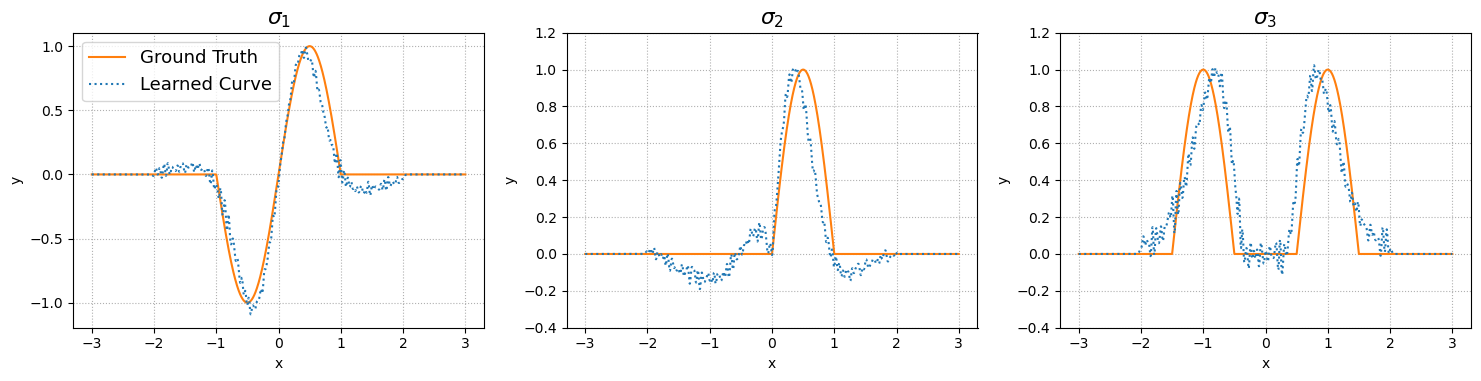

In [58]:
# Plot learned activation functions
def testrbf(x, paralist, coef):
    paralen = len(paralist)
    result = 0
    for i in range(paralen):
        c, h = paralist[i]
        result += coef[i]*np.exp(-(x-c)**2/(2*h**2))
    return result

task_list = ['sin', 'tru', 'zoi']
colors = ['#ff7f0e','#1f77b4']

y_gt = dict()
y_pred = dict()
for task_name in task_list:
    loadmodel = RFLAF(len(paralist), M, input_dim, paralist)
    checkpoint = torch.load(f'./models/model_{task_name}_LAF.pth')
    loadmodel.load_state_dict(checkpoint)
    loadmodel.eval()
    coef = loadmodel.a.detach().numpy()
    
    x_list = np.linspace(-3,3,1801)
    if task_name=='sin':
        myfunc = Mysin.apply
    elif task_name=='tru':
        myfunc = Myfunc2.apply
    elif task_name=='zoi':
        myfunc = Myfunc3.apply
    y_gt[task_name] = myfunc(torch.tensor(x_list)).numpy()
    
    y_list=[]
    for x_value in x_list:
        y_list.append(testrbf(x_value, paralist, coef))
    y_pred[task_name] = np.array(y_list)
    
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plt.rcParams.update({'font.size': 13})

axs[0].plot(x_list, y_gt['sin'], label='Ground Truth', ls='-', color=colors[0])
axs[0].plot(x_list, y_pred['sin']*(-3.6), label='Learned Curve', ls=':', color=colors[1])
axs[1].set_ylim(-1.2,1.2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title(r'$\sigma_1$')
axs[0].grid(ls=':')
axs[0].legend(loc='upper left')

axs[1].plot(x_list, y_gt['tru'], label='Ground Truth', ls='-', color=colors[0])
axs[1].plot(x_list, y_pred['tru']*(2.7), label='Learned Curve', ls=':', color=colors[1])
axs[1].set_ylim(-0.4,1.2)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].grid(ls=':')
axs[1].set_title(r'$\sigma_2$')

axs[2].plot(x_list, y_gt['zoi'], label='Ground Truth', ls='-', color=colors[0])
axs[2].plot(x_list, y_pred['zoi']*(-4.3), label='Learned Curve', ls=':', color=colors[1])
axs[2].set_ylim(-0.4,1.2)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].grid(ls=':')
axs[2].set_title(r'$\sigma_3$')

plt.tight_layout()
# plt.savefig(f"learned_func_all.pdf", format='pdf')
plt.show()

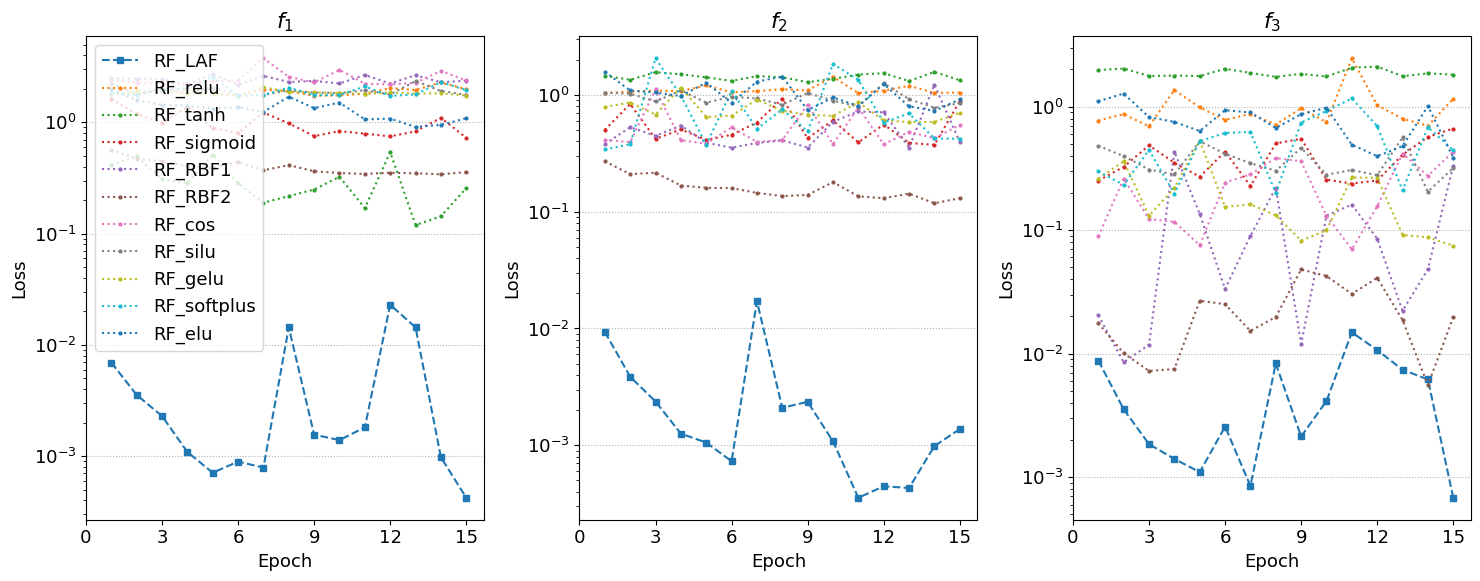

In [59]:
# Plot loss curves
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
plt.rcParams.update({'font.size': 13})
losstype = 'test'
task_list = ['sin', 'tru', 'zoi']

xlim = list(range(1,16))

for i in range(len(task_list)):
    task_name = task_list[i]
    RFLAF_loss_values = np.loadtxt(f"./losses/{task_name}_LAF_{losstype}_losses.txt")
    relu_loss_values = np.loadtxt(f"./losses/{task_name}_relu_{losstype}_losses.txt")
    tanh_loss_values = np.loadtxt(f"./losses/{task_name}_tanh_{losstype}_losses.txt")
    cos_loss_values = np.loadtxt(f"./losses/{task_name}_cos_{losstype}_losses.txt")
    silu_loss_values = np.loadtxt(f"./losses/{task_name}_silu_{losstype}_losses.txt")
    gelu_loss_values = np.loadtxt(f"./losses/{task_name}_gelu_{losstype}_losses.txt")
    softplus_loss_values = np.loadtxt(f"./losses/{task_name}_softplus_{losstype}_losses.txt")
    sigmoid_loss_values = np.loadtxt(f"./losses/{task_name}_sigmoid_{losstype}_losses.txt")
    elu_loss_values = np.loadtxt(f"./losses/{task_name}_elu_{losstype}_losses.txt")
    RBF1_loss_values = np.loadtxt(f"./losses/{task_name}_RBF1_{losstype}_losses.txt")
    RBF2_loss_values = np.loadtxt(f"./losses/{task_name}_RBF2_{losstype}_losses.txt")
    
    ax = axs[i]
    ax.semilogy(xlim,RFLAF_loss_values, label='RF_LAF', ls='--', marker = 's', markersize='5')
    ax.semilogy(xlim,relu_loss_values, label='RF_relu', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,tanh_loss_values, label='RF_tanh', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,sigmoid_loss_values, label='RF_sigmoid', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,RBF1_loss_values, label='RF_RBF1', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,RBF2_loss_values, label='RF_RBF2', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,cos_loss_values, label='RF_cos', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,silu_loss_values, label='RF_silu', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,gelu_loss_values, label='RF_gelu', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,softplus_loss_values, label='RF_softplus', ls=':', marker = 'o', markersize='2')
    ax.semilogy(xlim,elu_loss_values, label='RF_elu', ls=':', marker = 'o', markersize='2')
    
    # ax.plot(xlim,RFLAF_loss_values, label='RF_LAF', ls='--', marker = '^', markersize='3')
    # ax.plot(xlim,relu_loss_values, label='RF_relu', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,tanh_loss_values, label='RF_tanh', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,cos_loss_values, label='RF_cos', ls=':', marker = 'o', markersize='2')
    # # ax.plot(xlim,silu_loss_values, label='RF_silu', ls=':', marker = 'o', markersize='2')
    # # ax.plot(xlim,gelu_loss_values, label='RF_gelu', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,softplus_loss_values, label='RF_softplus', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,sigmoid_loss_values, label='RF_sigmoid', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,elu_loss_values, label='RF_elu', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,RBF1_loss_values, label='RF_RBF1', ls=':', marker = 'o', markersize='2')
    # ax.plot(xlim,RBF2_loss_values, label='RF_RBF2', ls=':', marker = 'o', markersize='2')
    
    ax.set_xticks([0, 3, 6, 9, 12, 15])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if i==0:
        ax.set_title(r'$f_1$')
        ax.legend(loc='upper left')
    elif i==1:
        ax.set_title(r'$f_2$')
    elif i==2:
        ax.set_title(r'$f_3$')
    # if losstype=='train':
    #     plt.title('Train Losses Curves')
    # else:
    #     plt.title('Test Losses Curves')
    ax.grid(True, axis='y', ls=':')

plt.tight_layout()
# plt.savefig(f"loss_curve_all_2.pdf", format='pdf')